
#### Install required packages

In [1]:
! pip install xgboost imbalanced-learn scikit-learn pandas numpy matplotlib seaborn --quiet



#### Import libraries

In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve,roc_curve
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns



#### Load dataset

In [23]:
df = pd.read_csv('CreditCard_ExamData.csv', low_memory=True)

#### Features and target

In [33]:

# Drop unnecessary columns
X = df.drop(columns=['is_fraud', 'ID', 'cc_num', 'first', 'last', 'street', 'city', 'state', 'zip', 'dob', 'trans_num'])

# Separate target
y = df['is_fraud']


cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()


for col in cat_cols:
    freq_map = X[col].value_counts()
    X[col] = X[col].map(freq_map)

X = X.fillna(X.median())

#### Train-test split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
print("Fraud ratio in train:", y_train.mean())
print("Fraud ratio in test:", y_test.mean())

Fraud ratio in train: 0.005093022466676332
Fraud ratio in test: 0.0050960915568991575



#### Apply SMOTE to handle imbalance

In [35]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Shape after SMOTE:", X_train_res.shape)
print("Fraud ratio after SMOTE:", y_train_res.mean())


Shape after SMOTE: (645036, 13)
Fraud ratio after SMOTE: 0.5


#### XGBoost Model Training

In [37]:

scale_pos_weight = (len(y_train_res) - sum(y_train_res)) / sum(y_train_res)

model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss'
)

model.fit(X_train_res, y_train_res)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


#### Predictions

In [38]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

#### Evaluation

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    138222
           1       0.54      0.94      0.68       708

    accuracy                           1.00    138930
   macro avg       0.77      0.97      0.84    138930
weighted avg       1.00      1.00      1.00    138930

ROC-AUC: 0.9959766986654647


Text(0.5, 1.0, 'Confusion Matrix')

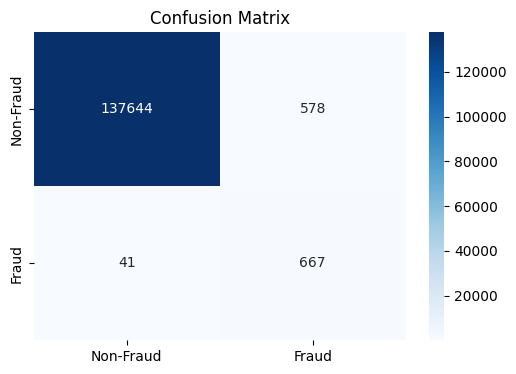

In [39]:
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix')


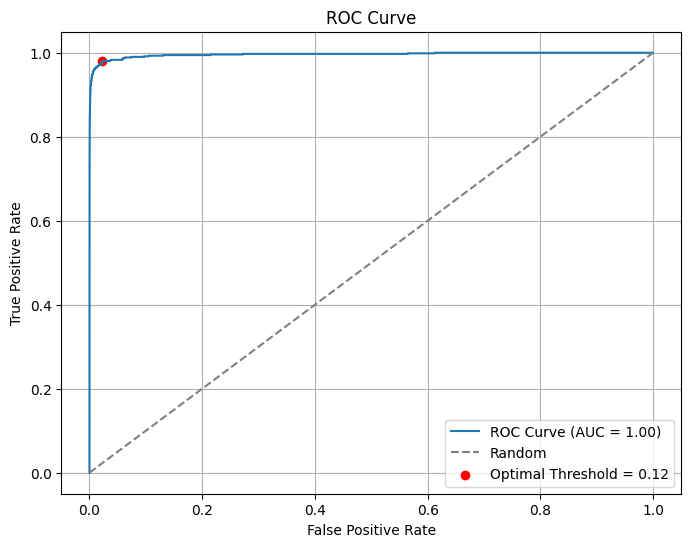

In [42]:

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = roc_auc_score(y_test, y_pred_proba)

# Compute Youden's J statistic
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f'Optimal Threshold = {optimal_threshold:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()

In [43]:
print(f"AUC Score: {auc_score:.4f}")
print(f"Optimal Threshold (Youden's J): {optimal_threshold:.4f}")

# Apply threshold to predictions
y_pred_custom = (y_pred_proba >= optimal_threshold).astype(int)

# Classification report
print("\nClassification Report at Optimal Threshold:")
print(classification_report(y_test, y_pred_custom))

AUC Score: 0.9960
Optimal Threshold (Youden's J): 0.1156

Classification Report at Optimal Threshold:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    138222
           1       0.18      0.98      0.30       708

    accuracy                           0.98    138930
   macro avg       0.59      0.98      0.65    138930
weighted avg       1.00      0.98      0.98    138930



Text(0.5, 1.0, 'Confusion Matrix')

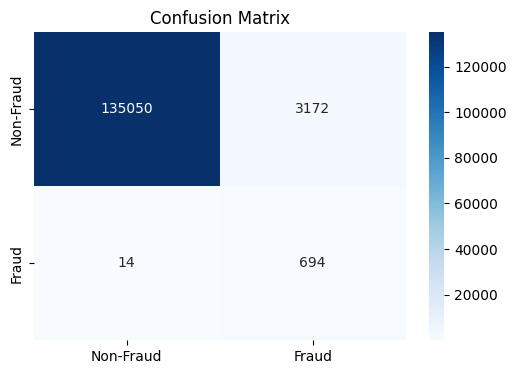

In [44]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_custom)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix')
